C:\Users\ayrto\AppData\Local\Temp\ipykernel_20952\1264832451.py:44: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataelo_clean = dataelo_clean.applymap(lambda x: pd.NA if isinstance(x, str) and x == "#N/A" else x)


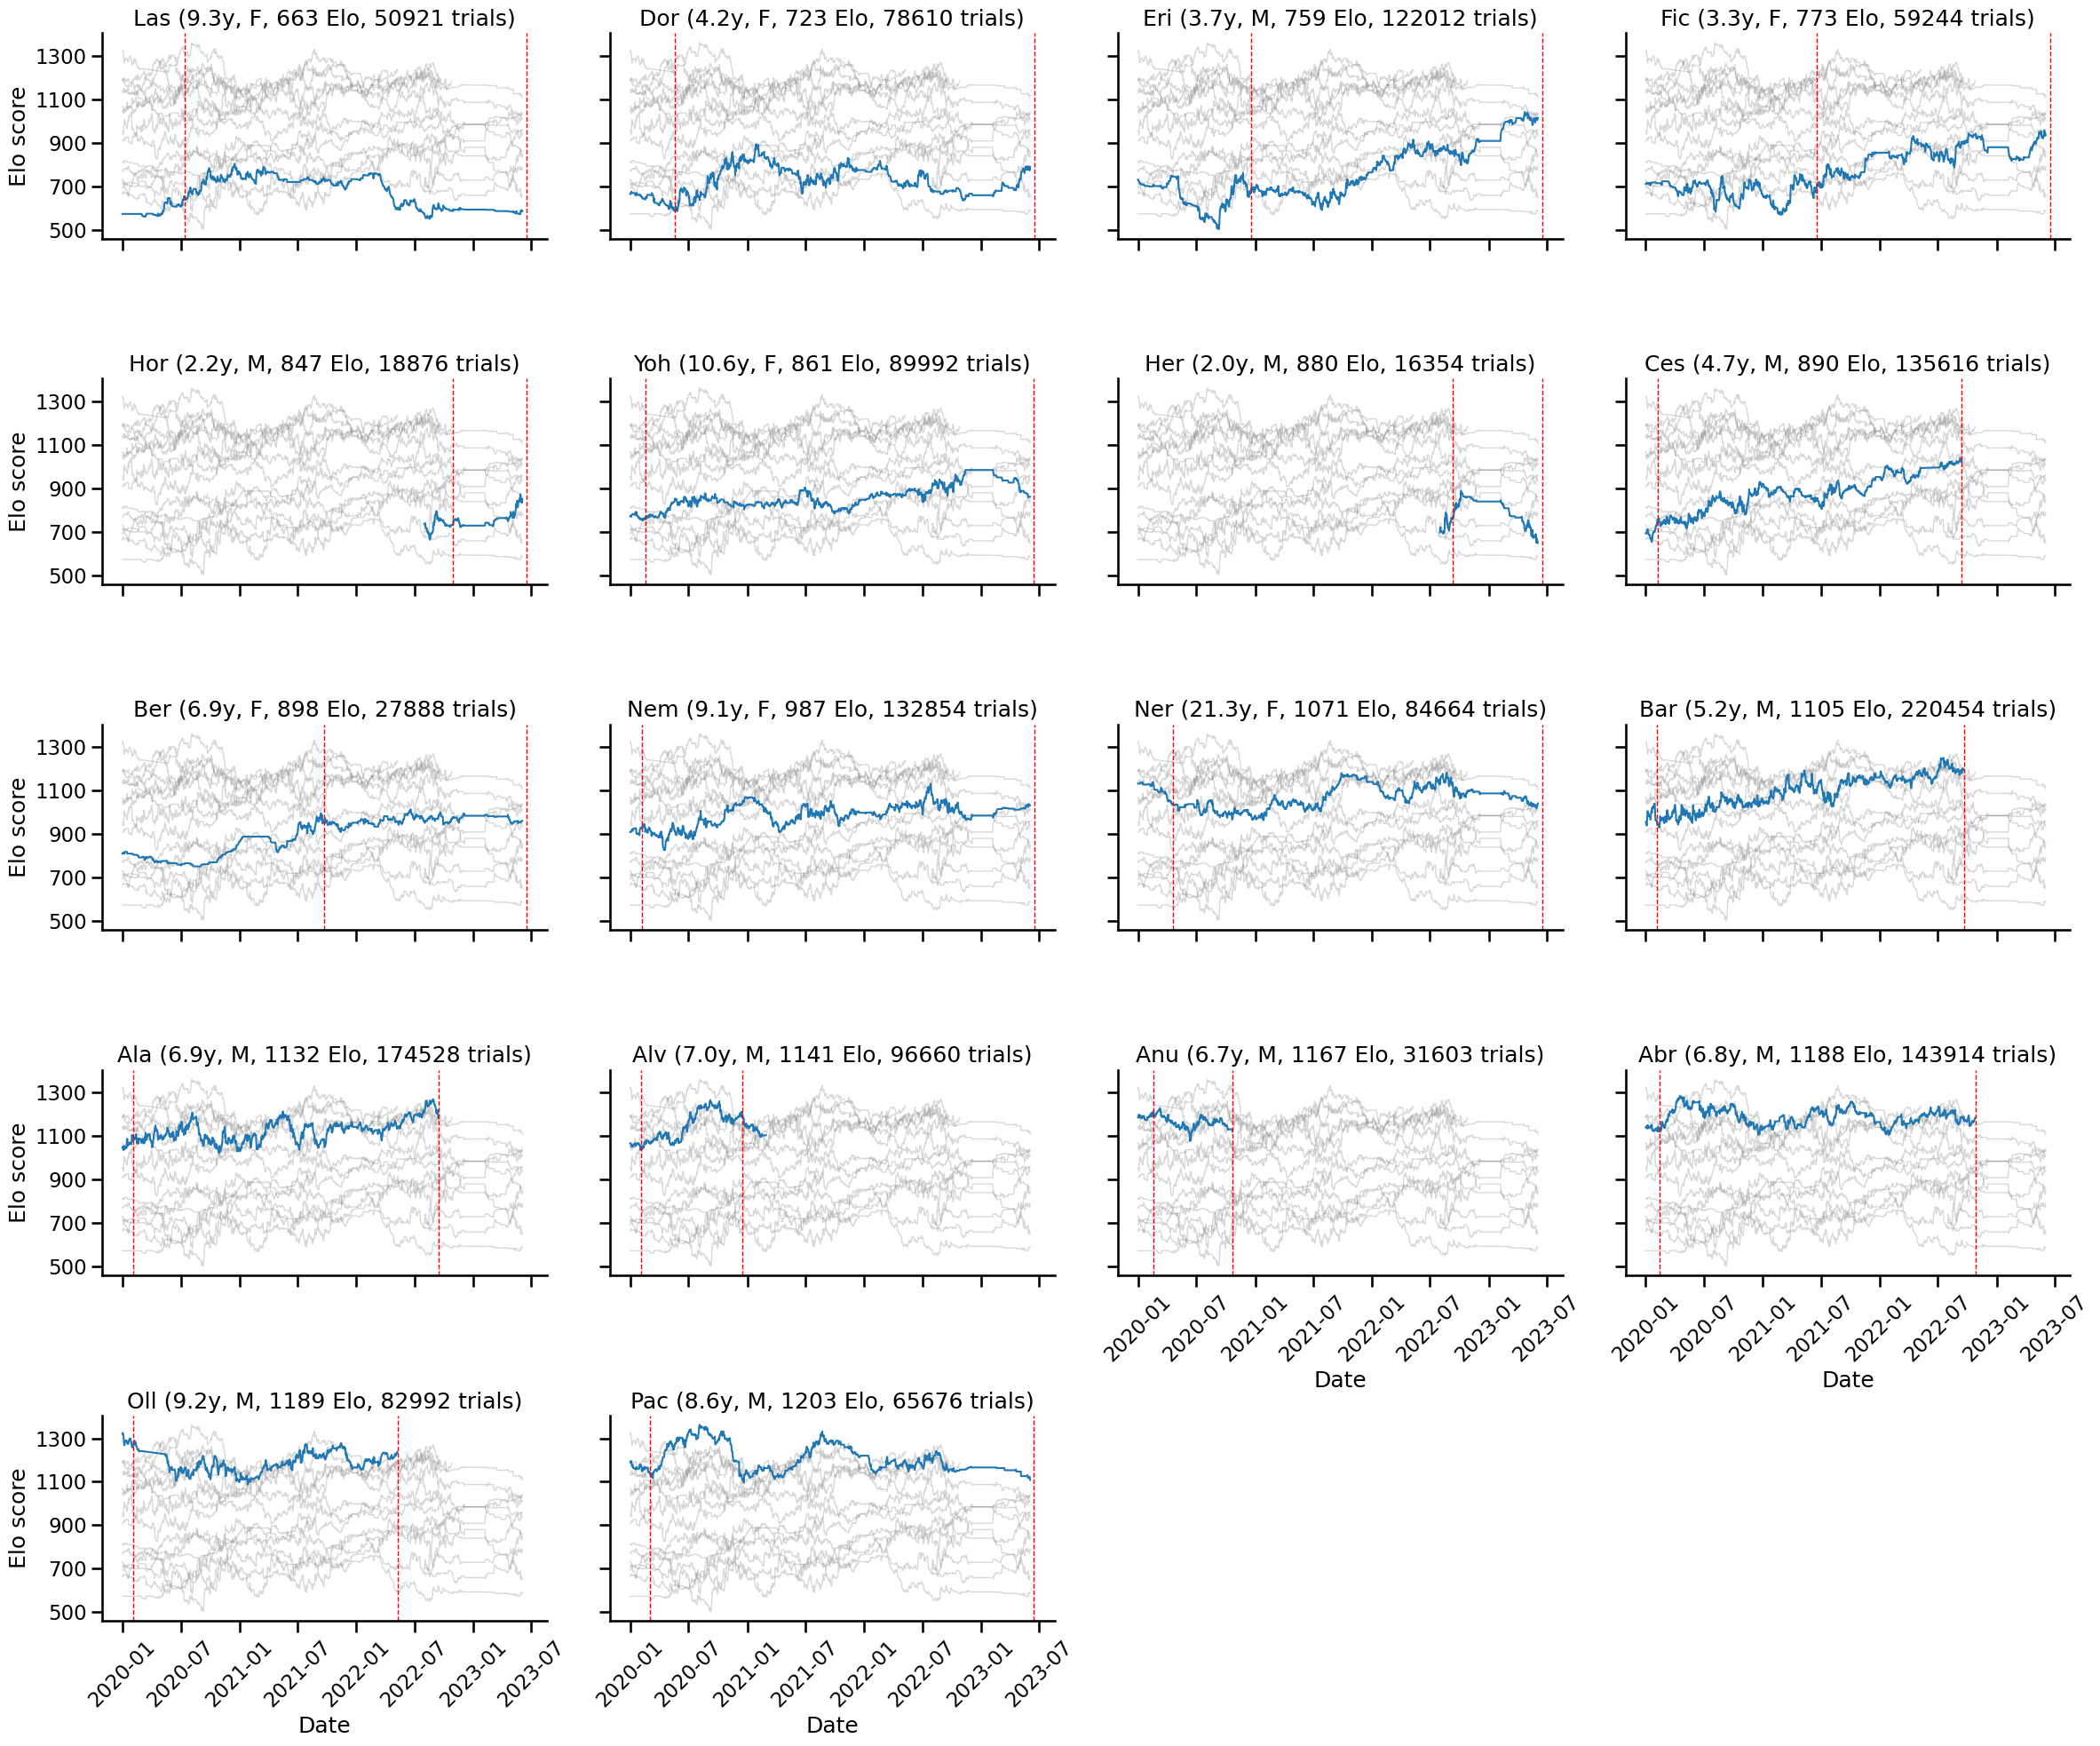

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Importation of dataset with Elo score
dataelo = pd.read_csv("elo_matrix_Tonk.csv", sep=";")

# Importation of trials periods
dataperiods = pd.read_csv("elo_dynamic_L0_P1+_lambdainbornv6.csv", sep=",")
dataperiods['date_start'] = pd.to_datetime(dataperiods['date_start'])
dataperiods['end'] = pd.to_datetime(dataperiods['date_end'])

# Importation of all trials dataset
datatrials = pd.read_csv("data-processed.csv", sep=",")
datatrials['datetime'] = pd.to_datetime(datatrials['date'].astype(str) + ' ' + datatrials['heure_debut'])

# Importation of dataset with demographic informations
infos = pd.read_csv("infos.csv", sep=";")


# Filtereing of individual not studied
monkeys_list = [
    'abr', 'ala', 'anu', 'bar', 'ber', 'ces', 'dor', 'eri', 'fic',
    'her', 'hor', 'las', 'nem', 'oll', 'pac', 'yoh', "ner", "alv"
]

infos = infos[infos['monkey'].isin(monkeys_list)]
dataperiods = dataperiods[dataperiods['monkey'].isin(monkeys_list)]

# Adding age and sex
dataperiods = dataperiods.merge(infos[['monkey', 'birthdate', 'gender']], on='monkey', how='left')

dataperiods['birthdate'] = pd.to_datetime(dataperiods['birthdate'], format='%d/%m/%Y', errors='coerce')
dataperiods['date_start'] = pd.to_datetime(dataperiods['date_start'], errors='coerce')
dataperiods['date_end'] = pd.to_datetime(dataperiods['date_end'], errors='coerce')

dataperiods['age_start'] = (dataperiods['date_start'] - dataperiods['birthdate']).dt.days / 365.25
dataperiods['age_end'] = (dataperiods['date_end'] - dataperiods['birthdate']).dt.days / 365.25


dataelo_clean = dataelo.copy()

# Replace #N/A by NaN
dataelo_clean = dataelo_clean.applymap(lambda x: pd.NA if isinstance(x, str) and x == "#N/A" else x)

# Date convertion
dataelo_clean = dataelo_clean.apply(lambda x: pd.to_numeric(x, errors='ignore') if x.name != 'Date' else x)

# Transformation dataset
dataelo_long = dataelo_clean.melt(id_vars=["Date"], var_name="monkey", value_name="eloscore")

# Correction of "Oll" name
dataelo_long['monkey'] = dataelo_long['monkey'].replace({'oli': 'oll'})

# Date convertion
dataelo_long['Date'] = pd.to_datetime(dataelo_long['Date'], format="%d/%m/%Y")


# Individual selection
dataelo_long_filtered = dataelo_long[dataelo_long['monkey'].isin(monkeys_list)]

# Date selection
start_date = pd.to_datetime("2020-01-01")
end_date = pd.to_datetime("2023-06-03")
dataelo_long_filtered = dataelo_long_filtered[(dataelo_long_filtered['Date'] >= start_date) & (dataelo_long_filtered['Date'] <= end_date)]
datatrials_filtered = datatrials[(datatrials['datetime'] >= start_date) & (datatrials['datetime'] <= end_date)]

# Showing first and last trial day
first_periods = dataperiods.sort_values(by='date_start').drop_duplicates(subset='monkey', keep='first')
last_periods = dataperiods.sort_values(by='end').drop_duplicates(subset='monkey', keep='last')
data_with_periods = dataelo_long_filtered.merge(first_periods[['monkey', 'date_start']], on="monkey", how="left")
data_with_periods = data_with_periods.merge(last_periods[['monkey', 'end']], on="monkey", how="left")

# Mean Elo score for all individual
elo_avg = dataelo_long_filtered.groupby('monkey')['eloscore'].mean().sort_values()

# Reorder individual on Elo score
sorted_monkeys = elo_avg.index.tolist()

sns.set_context("talk")

g = sns.FacetGrid(data=data_with_periods, col="monkey", col_wrap=4, height=4, aspect=1.5,
                  col_order=sorted_monkeys)


# Function for plot all Elo score evolution for all individual
def plot_with_others_and_first_period(data, **kwargs):
    current_monkey = data['monkey'].iloc[0]
    
    if current_monkey == "hor":
        data = data[data['Date'] >= "2022-08-01"]
    elif current_monkey == "her":
        data = data[data['Date'] >= "2022-08-01"]
    
    if current_monkey in ["abr", "ala", "bar", "ces"]:
        last_date = data['end'].max()
        data = data[data['Date'] <= last_date]

    for monkey in monkeys_list:
        if monkey != current_monkey:
            other_data = data_with_periods[data_with_periods['monkey'] == monkey]
            if monkey == "hor":
                other_data = other_data[other_data['Date'] >= "2022-08-01"]
            elif monkey == "her":
                other_data = other_data[other_data['Date'] >= "2022-08-01"]
            elif monkey == "abr":
                last_date = other_data['end'].max()
                other_data = other_data[other_data['Date'] <= last_date]
            elif monkey == "ala":
                last_date = other_data['end'].max()
                other_data = other_data[other_data['Date'] <= last_date]
            elif monkey == "bar":
                last_date = other_data['end'].max()
                other_data = other_data[other_data['Date'] <= last_date]
            elif monkey == "ces":
                last_date = other_data['end'].max()
                other_data = other_data[other_data['Date'] <= last_date]
            
            sns.lineplot(data=other_data, x="Date", y="eloscore", color='gray', alpha=0.3, linewidth=1)
    

    sns.lineplot(data=data, x="Date", y="eloscore", linewidth=1.5, **kwargs)
    

    if pd.notna(data['date_start'].iloc[0]):
        plt.axvline(x=data['date_start'].iloc[0], color='red', linestyle='--', linewidth=1)

    if pd.notna(data['end'].iloc[-1]):  
        plt.axvline(x=data['end'].iloc[-1], color='red', linestyle='--', linewidth=1)

g.map_dataframe(plot_with_others_and_first_period)


for ax in g.axes.flat:
    ax.set_yticks(range(500, 1401, 200))

# Add name, age, sex and Elo score labelA
def update_titles(g, monkey):
    first_period = first_periods[first_periods['monkey'] == monkey].iloc[0]
    age_start = first_period['age_start']
    gender = 'M' if first_period['gender'] == 1 else 'F'

    avg_elo = dataelo_long_filtered[dataelo_long_filtered['monkey'] == monkey]['eloscore'].mean()

    ntrials = len(datatrials_filtered[datatrials_filtered['subject_id'] == monkey])

    return f"{monkey.capitalize()} ({age_start:.1f}y, {gender}, {avg_elo:.0f} Elo, {ntrials} trials)"

for ax in g.axes.flat:
    monkey = ax.get_title().split(" = ")[-1]
    ax.set_title(update_titles(g, monkey))

g.set_axis_labels("Date", "Elo score")

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()


plt.show()
